In [13]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
from matplotlib.markers import TICKDOWN
import matplotlib
import datetime
from scipy.stats import norm
import imageio
from matplotlib.gridspec import GridSpec

from lib.analysis.laminar_dist import Line

# based on reference http://www.georgemather.com/Model.html#Refs

In [14]:
# an object moving in circles?
stim_type = ['circular_point',  # 0
             'single_pulse',    # 1
             'translating_bar', # 2
             'circular_edge',   # 3
             'double_pulse',    # 4
             'two_circular_points',][2]   # 5

In [15]:
# intralaminar PV velocities over barrels of size 100-300 um
barrel_latency_PV = 200 / 57  # ms
barrel_latency_PV_se = 100 / 41
# Katherine S Scheuer, John M Judge, Xinyu Zhao, Meyer B Jackson, Velocity of conduction between columns and layers in barrel cortex reported by parvalbumin interneurons, Cerebral Cortex 33:17, 1 Sept 2023, p 9917–9926
print(barrel_latency_PV, barrel_latency_PV_se)

3.508771929824561 2.4390243902439024


In [16]:
barrel_latency_PV_excitatory_L4 = 1.028032
barrel_latency_PV_excitatory_L4_se = 1.0011922707332492

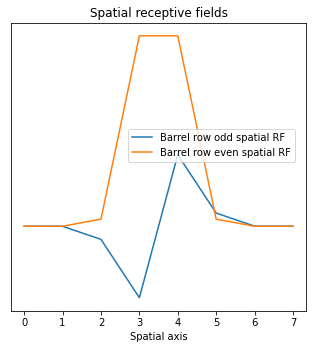

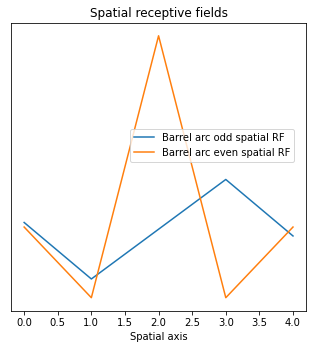

In [17]:
# Barrel cortex motion
# from http://www.georgemather.com/Model.html#Refs

# Define the space axis of the filters
nx_row = 8
ny_arc = 5
max_x = 0.2  # Half-width of filter (deg)
max_y = 0.2
dx = (max_x * 2) / nx_row  # Spatial sampling interval of filter (deg)
dy = (max_y * 2) / ny_arc

# A row vector holding spatial sampling intervals
x_filt = np.linspace(-max_x, max_x, nx_row)
y_filt = np.linspace(-max_y, max_y, ny_arc)

# Spatial filter parameters
sx = 0.05 # standard deviation of Gaussian, in deg.
sfx = 2.0 # spatial frequency of carrier, in cpd
sy = 0.11 # standard deviation of Gaussian, in deg.
sfy = 4.0 # spatial frequency of carrier, in cpd

# Spatial filter response
gauss_x = np.exp(-x_filt ** 2 / sx ** 2)  # Gaussian envelope
even_x = np.cos(2 * np.pi * sfx * x_filt) * gauss_x  # Even Gabor
odd_x = np.sin(2 * np.pi * sfx * x_filt) * gauss_x  # Odd Gabor
gauss_y = np.exp(-y_filt ** 2 / sy ** 2)  # Gaussian envelope
even_y = np.cos(2 * np.pi * sfy * y_filt) * gauss_y  # Even Gabor
odd_y = np.sin(2 * np.pi * sfy * y_filt) * gauss_y  # Odd Gabor

plt.plot(odd_x, label="Barrel row odd spatial RF")
plt.plot(even_x, label="Barrel row even spatial RF")
plt.xlabel("Spatial axis")
plt.title("Spatial receptive fields")
plt.yticks([])
plt.legend(bbox_to_anchor=(0.68, 0.65), loc='upper center')
plt.show()
plt.plot(odd_y, label="Barrel arc odd spatial RF")
plt.plot(even_y, label="Barrel arc even spatial RF")
plt.xlabel("Spatial axis")
plt.title("Spatial receptive fields")
plt.yticks([])
plt.legend(bbox_to_anchor=(0.68, 0.65), loc='upper center')
plt.show()

(0.0, 40.0)

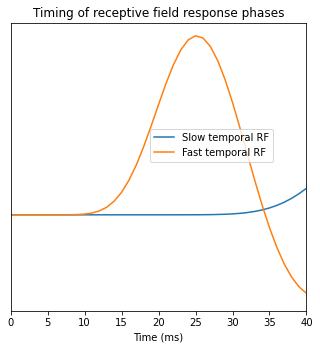

In [18]:
# Define the time axis of the filters
nt = 100  # number temporal samples in the filter
max_t = 0.5  # Duration of impulse response (sec)
dt = max_t / nt  #Temporal sampling interval (sec)

# temporal sampling intervals
t_filt = np.linspace(0, max_t, nt)

# Temporal filter parameters
k = 100 # Scales the response into time units
slow_n = 30 # Width of the slow temporal filter
fast_n = 15 # Width of the fast temporal filter
beta = 0.9 # Weighting of  -ve phase of the temporal resp relative to +ve phase.

# Temporal filter response
slow_t = (k * t_filt) ** slow_n * np.exp(-k * t_filt) * (1 / np.math.factorial(slow_n) - beta * ((k * t_filt) ** 2) / np.math.factorial(slow_n + 2))
fast_t = (k * t_filt) ** fast_n * np.exp(-k * t_filt) * (1 / np.math.factorial(fast_n) - beta * ((k * t_filt) ** 2) / np.math.factorial(fast_n + 2))

# To reflect casuality, have to reflect temporal component across t = 0
#slow_t = np.flip(slow_t)
#fast_t = np.flip(fast_t)

plt.plot(slow_t, label="Slow temporal RF")
plt.plot(fast_t, label="Fast temporal RF")
plt.xlabel("Time (ms)")
plt.title("Timing of receptive field response phases")
plt.yticks([])
plt.legend(bbox_to_anchor=(0.68, 0.65), loc='upper center')
#plt.annotate("EPSPs", xy=(5.08, 0.2))
#plt.annotate("IPSPs", xy=(10.08, -0.01))
ax = plt.gca()
ax.set_xlim([0, 40])




In [19]:
# spatiotemporal filters
# need all 2 x 2 x 2 = 8 combinations of t, x, y filters
# The orientation is controlled by the coupling of even and odd spatial functions
# Note that :
#       - Even is slightly more influential than odd function
#       - Fast function is slightly more influential than slow function
#       - "odd" is positive to the right first, and negative to the immediate left
#                Then in a few milliseconds, this switches.

# As an example, consider left_1 = o_fast + e_slow
#    Odd filter responds positively to signal that is high at the right
#    first, then high at the left next -- which is left-moving signal.
#    e_slow is smaller overall
# left_1 = -o_slow + e_fast
#    Odd portion is flipped, but smaller, so function is more positive to the right still

target_shape = (nt, nx_row, ny_arc)

# X-axis
e_slow_x = slow_t.reshape(-1, 1) @ np.transpose(even_x).reshape(1, -1)  # SE/TS
e_slow_x = np.tile(e_slow_x.reshape(e_slow_x.shape + (1,)), (1, 1, ny_arc))

e_fast_x = fast_t.reshape(-1, 1) @ np.transpose(even_x).reshape(1, -1)   # SE/TF
e_fast_x = np.tile(e_fast_x.reshape(e_fast_x.shape + (1,)), (1, 1, ny_arc))

o_slow_x = slow_t.reshape(-1, 1) @ np.transpose(odd_x).reshape(1, -1)   # SO/TS
o_slow_x = np.tile(o_slow_x.reshape(o_slow_x.shape + (1,)), (1, 1, ny_arc))

o_fast_x = fast_t.reshape(-1, 1) @ np.transpose(odd_x).reshape(1, -1)   # SO/TF
o_fast_x = np.tile(o_fast_x.reshape(o_fast_x.shape + (1,)), (1, 1, ny_arc))

# check accuracy in new dim
for a in [e_slow_x, e_fast_x, o_slow_x, o_fast_x]:
    for p in range(1, ny_arc):
        assert (a[:, :, 0] == a[:, :, p]).all()

# Y-axis
e_slow_y = slow_t.reshape(-1, 1) @ np.transpose(even_y).reshape(1, -1)
e_slow_y = np.tile(e_slow_y.reshape((e_slow_y.shape[0], 1, e_slow_y.shape[1])), (1, nx_row, 1))

e_fast_y = fast_t.reshape(-1, 1) @ np.transpose(even_y).reshape(1, -1)
e_fast_y = np.tile(e_fast_y.reshape((e_fast_y.shape[0], 1, e_fast_y.shape[1])), (1, nx_row, 1))

o_slow_y = slow_t.reshape(-1, 1) @ np.transpose(odd_y).reshape(1, -1)
o_slow_y = np.tile(o_slow_y.reshape((o_slow_y.shape[0], 1, o_slow_y.shape[1])), (1, nx_row, 1))

o_fast_y = fast_t.reshape(-1, 1) @ np.transpose(odd_y).reshape(1, -1)
o_fast_y = np.tile(o_fast_y.reshape((o_fast_y.shape[0], 1, o_fast_y.shape[1])), (1, nx_row, 1))

# check accuracy in new dim
for a in [e_slow_y, e_fast_y, o_slow_y, o_fast_y]:
    for p in range(1, nx_row):
        assert (a[:, 0, :] == a[:, p, :]).all()


# Spatiotemporally oriented filters of different components in each dim
left_1 = o_fast_x + e_slow_x  # L1_x
left_2 = -o_slow_x + e_fast_x  # L2_x
right_1 = -o_fast_x + e_slow_x  # R1_x
right_2 = o_slow_x + e_fast_x  # R2_x
down_1 = o_fast_y + e_slow_y  # L1_y
down_2 = -o_slow_y + e_fast_y  # L2_y
up_1 = -o_fast_y + e_slow_y  # R1_y
up_2 = o_slow_y + e_fast_y  # R2_y

#for im in [left_1_1, left_2_1, right_1_1, right_2_1,
#          left_1_2, left_2_2, right_1_2, right_2_2]:
    #print(im.shape)
    #plt.imshow(im[0,:,:])
    #ax = plt.gca()
    #ax.set_xlim([20, 60])
    #ax.set_ylim([0, 20])
    #plt.show()

In [20]:
stim = np.zeros((120, 16, 10))
if 'circular_point' in stim_type:
    for i_t in range(120):
        freq = 20  # Hz (20 Hz => 50 ms period)
        i_x = int(4 * np.sin(2 * i_t * np.pi / (1000 / freq))) + nx_row
        i_y = int(3 * np.cos(2 * i_t * np.pi / (1000 / freq))) + ny_arc
        #for i_x in range(6,9):
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                stim[i_t, i_x+dx, i_y+dy] = 1
                if stim_type == 'two_circular_points':
                    stim[i_t, nx_row-(i_x+dx), i_y+dy] = 1
    
if stim_type == 'single_pulse':
    for i_t in range(50,54):
        for i_y in range(6,11):
            for i_x in range(3, 8):
                stim[i_t, i_y, i_x] = 1
elif stim_type == "translating_bar":
    for i_t in range(120):
        freq = 20  # Hz (20 Hz => 50 ms period)
        i_y = int(5 * np.sin(2 * i_t * np.pi / (1000 / freq))) + 8
        for i_x in range(6,9):
            stim[i_t, i_y, i_x] = 1
elif stim_type == 'circular_edge':
    for i_t in range(120):
        freq = 20  # Hz (20 Hz => 50 ms period)
        y = int(4 * np.sin(2 * i_t * np.pi / (1000 / freq))) + 8
        x = int(3 * np.cos(2 * i_t * np.pi / (1000 / freq))) + 5
        #for i_x in range(6,9):
        ln = Line([8, 5], [y, x])
        for i_x in range(stim.shape[2]):
            for i_y in range(stim.shape[1]):
                if ln.is_point_left_of_line([i_y, i_x]):
                    stim[i_t, i_y, i_x] = 1
elif stim_type == 'double_pulse':
    onset = 30
    duration = 2  # ms
    IPI = 15
    onset1 = onset
    end1 = onset1 + duration * 2
    onset2 = onset1 + IPI
    end2 = onset2 + duration * 2
    for i_t in [g for g in range(onset1, end1)] + [g for g in range(onset2, end2)]:
        for i_y in range(6,11):
            for i_x in range(3, 8):
                stim[i_t, i_y, i_x] = 1
                
# To reflect casuality, center the convolution properly (ORIGIN).
t_origin = -int(nt / 2)  # translate left, so that the PAST STIM determines the present response
# Rightward responses to stim
resp_right_1 = convolve(stim, right_1, mode='wrap', origin=(t_origin, 0, 0))
resp_right_2 = convolve(stim, right_2, mode='wrap', origin=(t_origin, 0, 0))

# Leftward responses
resp_left_1 = convolve(stim, left_1, mode='wrap', origin=(t_origin, 0, 0))
resp_left_2 = convolve(stim, left_2, mode='wrap', origin=(t_origin, 0, 0))

# upward responses
resp_up_1 = convolve(stim, up_1, mode='wrap', origin=(t_origin, 0, 0))
resp_up_2 = convolve(stim, up_2, mode='wrap', origin=(t_origin, 0, 0))

# downward responses
resp_down_1 = convolve(stim, down_1, mode='wrap', origin=(t_origin, 0, 0))
resp_down_2 = convolve(stim, down_2, mode='wrap', origin=(t_origin, 0, 0))

In [21]:
# square and normalize
resp_left_1 = resp_left_1 ** 2
resp_left_2 = resp_left_2  ** 2
resp_up_1 = resp_up_1 ** 2
resp_up_2 = resp_up_2  ** 2
resp_right_1 = resp_right_1 ** 2
resp_right_2 = resp_right_2 ** 2
resp_down_1 = resp_down_1 ** 2
resp_down_2 = resp_down_2 ** 2

# Calc left and right energy
energy_right = resp_right_1 + resp_right_2
energy_left = resp_left_1 + resp_left_2
energy_up = resp_up_1 + resp_up_2
energy_down = resp_down_1 + resp_down_2

# Calc total energy
total_energy_x = np.sum(energy_right)+np.sum(energy_left)
total_energy_y = np.sum(energy_down)+np.sum(energy_up)

# Normalise
RR1 = np.sum(resp_right_1) / total_energy_x
RR2 = np.sum(resp_right_2) / total_energy_x
LR1 = np.sum(resp_left_1) / total_energy_x
LR2 = np.sum(resp_left_2) / total_energy_x
UR1 = np.sum(resp_up_1) / total_energy_y
UR2 = np.sum(resp_up_2) / total_energy_y
DR1 = np.sum(resp_down_1) / total_energy_y
DR2 = np.sum(resp_down_2) / total_energy_y

# directional energy
right_Total = RR1 + RR2
left_Total = LR1 + LR2
up_Total = UR1 + UR2
down_Total = DR1 + DR2

# net motion energy
motion_energy_x = right_Total - left_Total
motion_energy_y = up_Total - down_Total
print('Net motion energy =', motion_energy_x, motion_energy_y)

Net motion energy = 0.0003961196840390757 0.0


In [22]:
# Generate motion contrast matrix
energy_opponent_x = energy_right - energy_left  # L-R difference matrix
energy_flicker_x = total_energy_x / (energy_left.shape[0] * energy_left.shape[1])  # A value for average total energy
energy_opponent_y = energy_up - energy_down
energy_flicker_y = total_energy_y / (energy_down.shape[0] * energy_down.shape[1])

# Re-scale L-R matrix using average energy.
motion_contrast_x = energy_opponent_x #/ energy_flicker_x
motion_contrast_y = energy_opponent_y #/ energy_flicker_y

# per frame
motion_contrast_per_frame_x = np.sum(motion_contrast_x, axis=(1,2))
motion_contrast_per_frame_y = np.sum(motion_contrast_y, axis=(1,2))

In [23]:
print("***************** Simulation summary *****************")
print("Stimulus")
print("\t ", stim_type)
print("Parameters")
print("\t X standard deviation of Gaussian, in deg. \t\tsx =", sx)
print("\t X spatial frequency of carrier, in cpd \t\tsfx =", sfx)
print("\t Y standard deviation of Gaussian, in deg. \t\tsy =", sy)
print("\t Width of the slow temporal filter \t\t\tslow_n =", slow_n)
print("\t Width of the fast temporal filter \t\t\tfast_n =", fast_n)
print("\t Weighting of -ve temp resp relative to +ve phase. \tbeta =", beta)
print("Standard deviation of energy")
print("\t X-std:", np.std(motion_contrast_per_frame_x))
print("\t Y-std:", np.std(motion_contrast_per_frame_y))
print("*******************************************************")

***************** Simulation summary *****************
Stimulus
	  translating_bar
Parameters
	 X standard deviation of Gaussian, in deg. 		sx = 0.05
	 X spatial frequency of carrier, in cpd 		sfx = 2.0
	 Y standard deviation of Gaussian, in deg. 		sy = 0.11
	 Width of the slow temporal filter 			slow_n = 30
	 Width of the fast temporal filter 			fast_n = 15
	 Weighting of -ve temp resp relative to +ve phase. 	beta = 0.9
Standard deviation of energy
	 X-std: 0.4960066078648774
	 Y-std: 1.8232824913785743e-16
*******************************************************


-0.18465523549384477 2.5131806358213993e-16


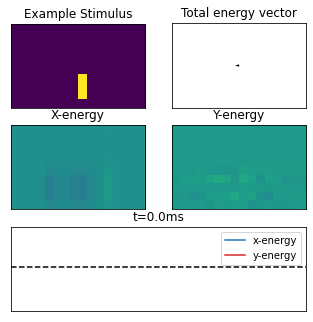

-0.31640788651261625 1.2869479787402938e-16


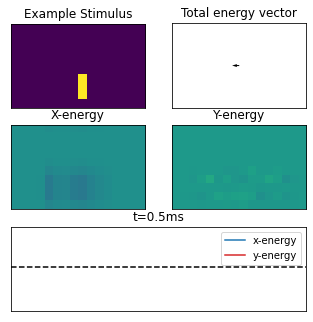

-0.3911277129707353 2.1025390629925145e-16


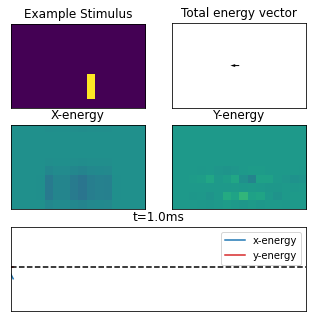

-0.3931903403350193 1.6615398293340355e-17


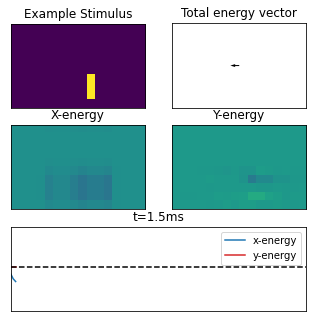

-0.3156312358878407 -1.5362467157761794e-16


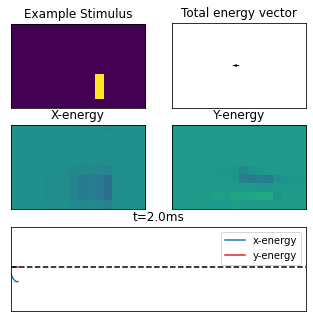

-0.16751131964137522 -3.752694769515452e-17


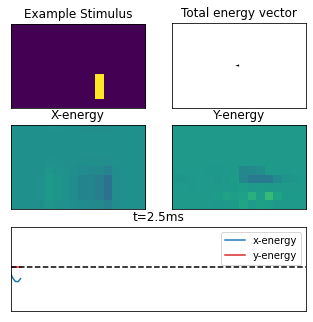

0.03178151908383181 8.348356728138384e-18


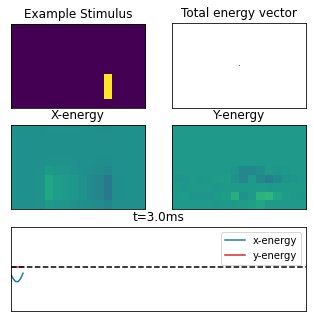

0.2558286810176684 4.277177570455315e-17


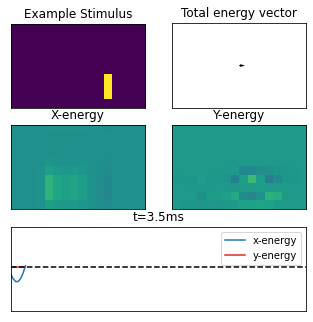

0.4677826726766267 8.803721640582296e-17


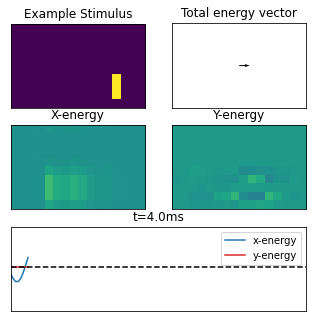

0.6345004859712134 3.5561831257524545e-17


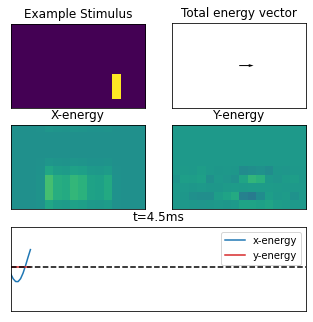

0.7299071205734363 1.1362438767648086e-16


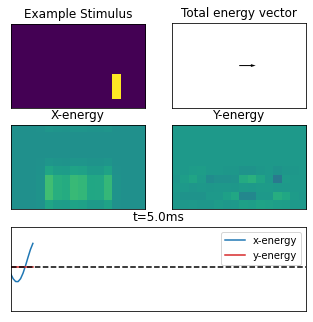

0.7411893639843283 -5.421010862427522e-17


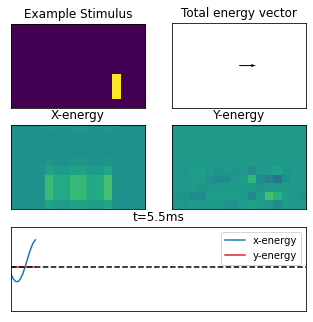

0.6641810777870217 4.3151246464923076e-16


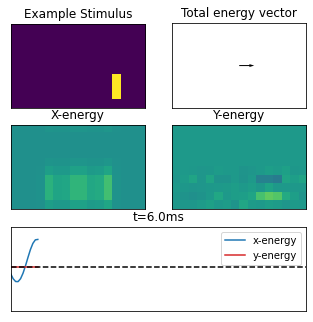

0.5038919997455258 1.3183898417423734e-16


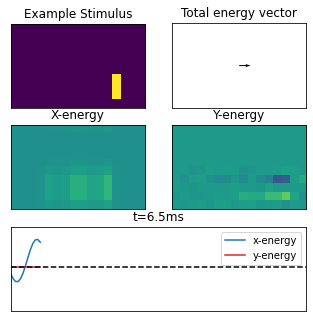

0.2925530845112466 2.47198095326695e-17


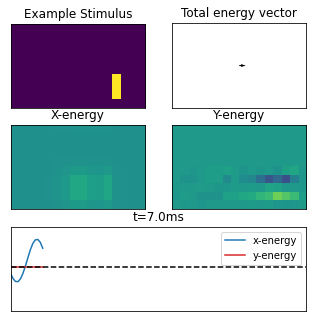

0.059694503052988526 8.630249292984615e-17


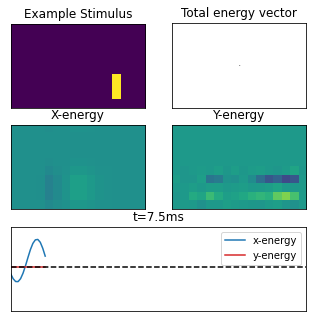

-0.16355025408186924 -1.8214596497756474e-16


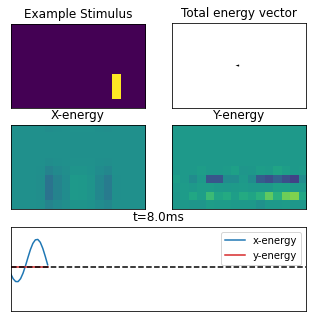

-0.3493082735079901 -1.687018580387445e-16


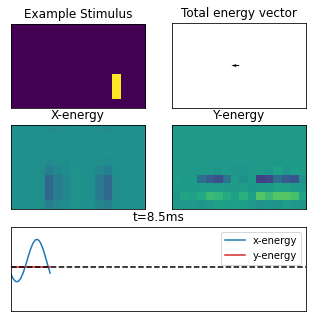

-0.47685980589456634 1.3183898417423734e-16


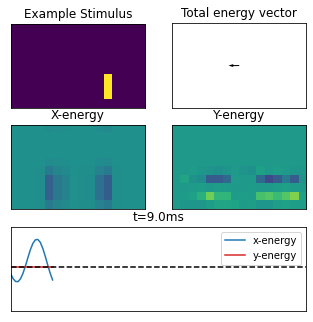

-0.5350383912997533 7.806255641895632e-18


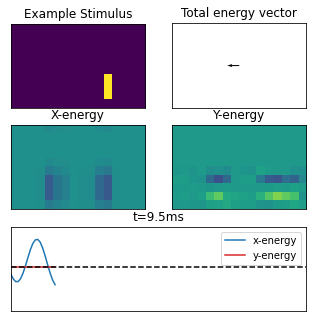

-0.5229600360165538 1.9949319973733282e-17


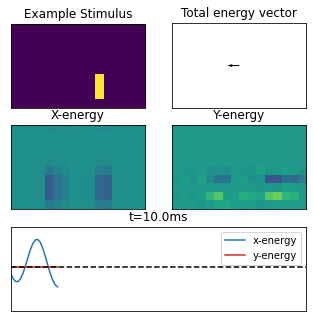

-0.4491954801347957 3.5561831257524545e-17


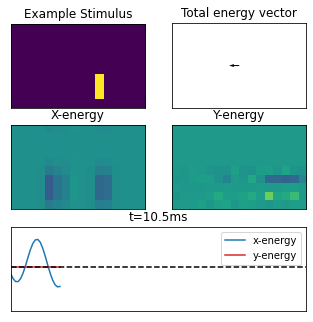

-0.3297007078891924 1.474514954580286e-17


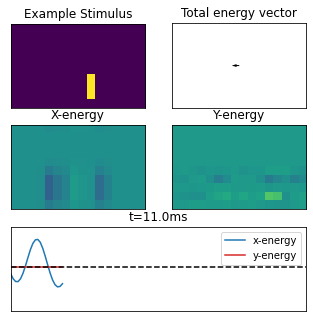

-0.18316911317917767 1.0842021724855044e-17


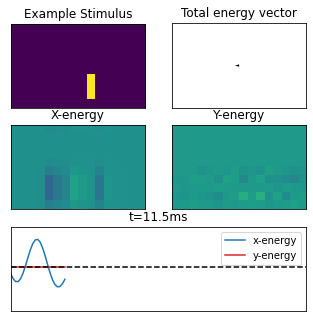

-0.03389753980019915 1.5612511283791264e-16


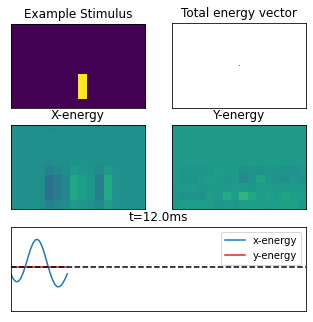

0.09853273974135533 2.452465314162211e-16


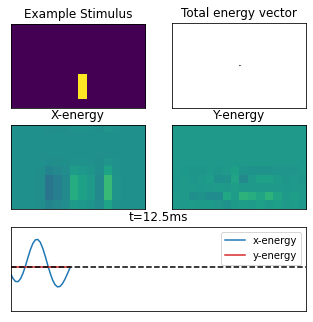

0.19957439858369055 1.5851035761738075e-16


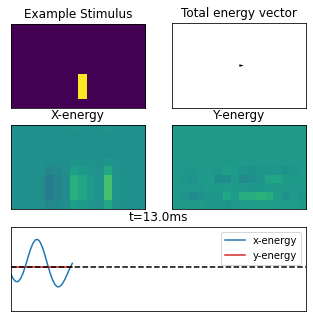

0.26335303063486337 1.2923689896027213e-16


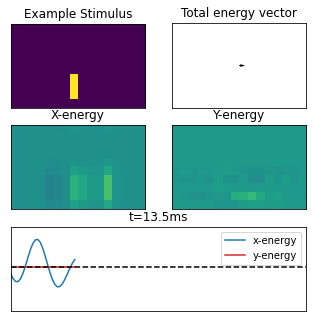

0.2859717988363225 6.900946827870236e-17


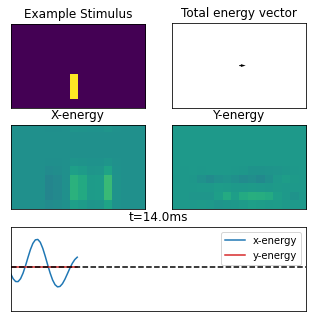

0.274818925554547 6.08237418764368e-17


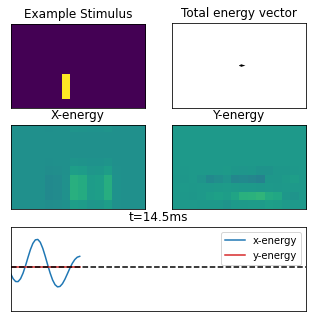

0.2416869520216952 9.448821933211171e-17


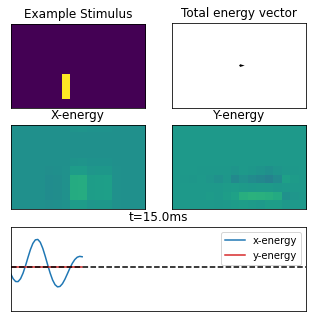

0.20262564205076844 1.3696183943923135e-16


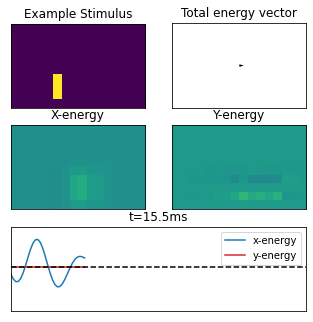

0.1738440784888255 2.0342343261259277e-16


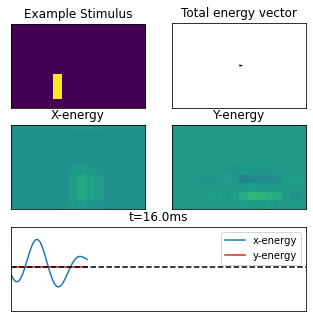

0.16980953863751913 3.7651800351579806e-16


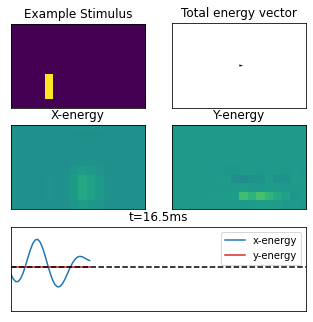

0.19715548761360735 3.7771147293847937e-16


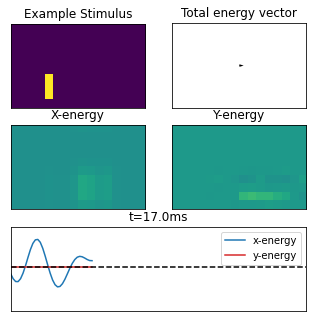

0.254897367412017 2.4515505185791764e-16


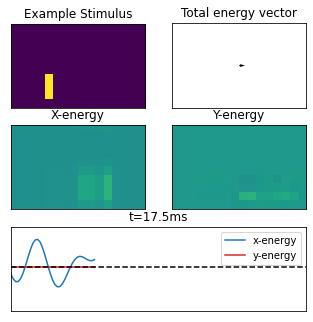

0.3358866454966669 4.3503612170980865e-17


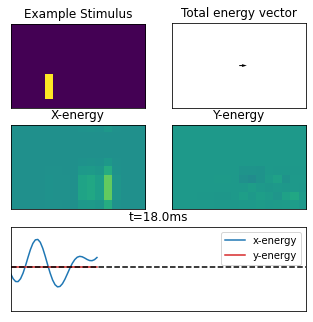

0.4208943849592622 1.2408693864096598e-16


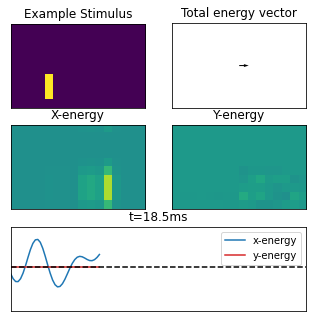

0.48010670893058044 -1.860761978528247e-17


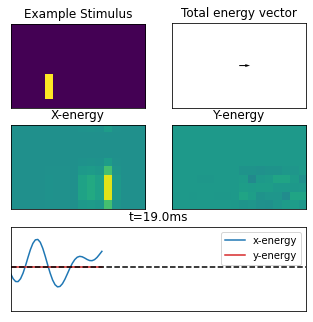

0.5026008896425095 -8.953477065656856e-17


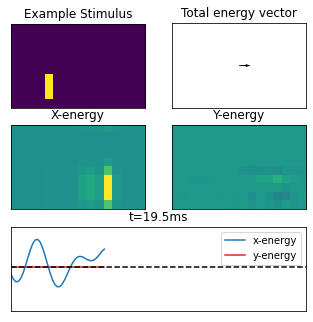

0.4733035638934161 -1.7802430265622532e-16


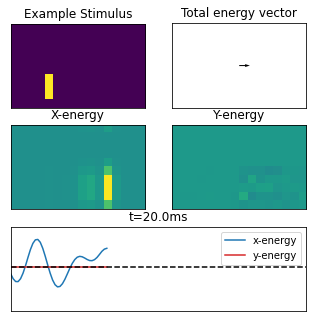

0.3847756619417478 -4.658681209898652e-16


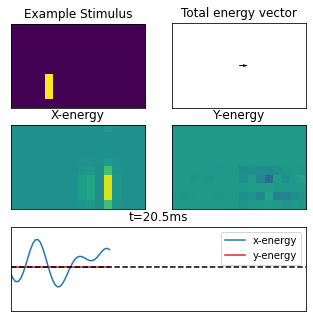

0.23846698230196575 -3.076423664427619e-16


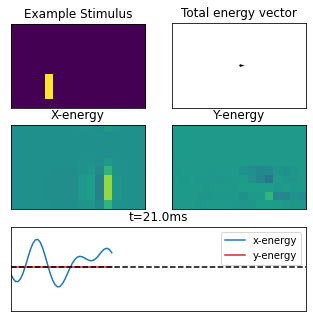

0.04415930545814148 -2.6465375030371163e-16


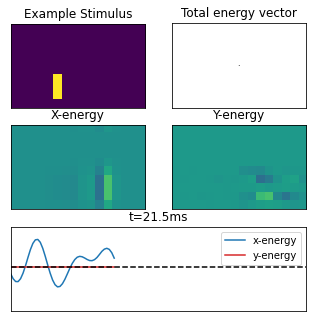

-0.182042857134217 -3.1452705023804484e-16


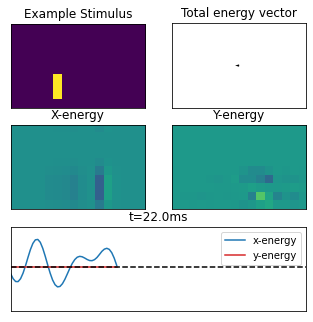

-0.4205058331374095 -2.209604027525458e-16


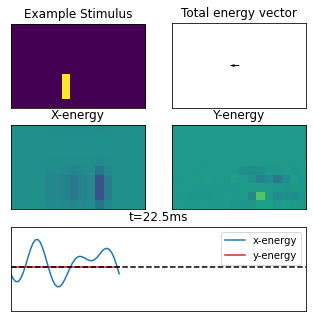

-0.650925303944698 -2.8536201179818477e-16


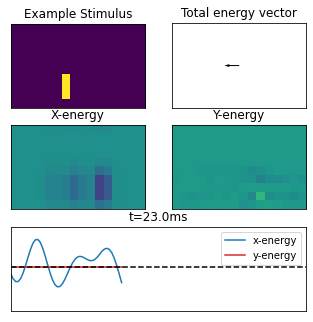

-0.8547041540520864 -2.409097227262791e-16


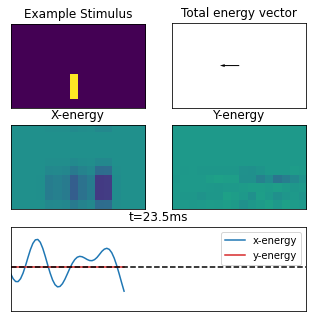

-1.021392727992846 -3.4661943454361577e-16


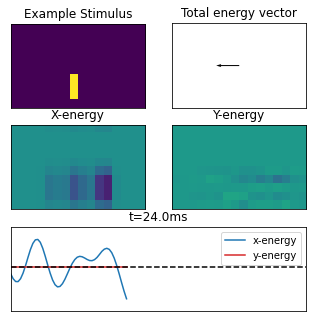

-1.1370056008196388 -3.2526065174565133e-16


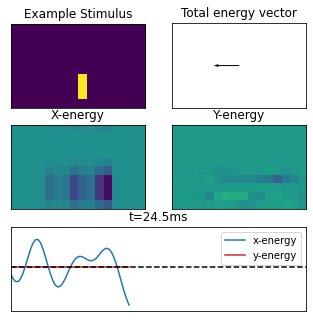

-1.1919069069035209 -3.2260435642306184e-16


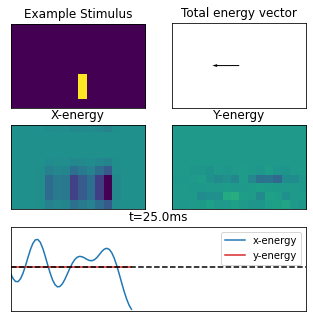

-1.1855718161235482 -2.3115190317390955e-16


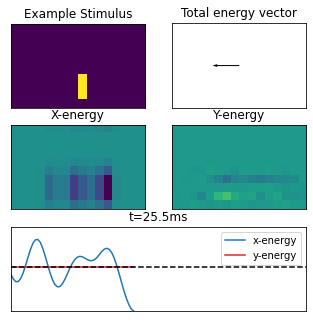

-1.1200876948873075 -2.542454094478508e-16


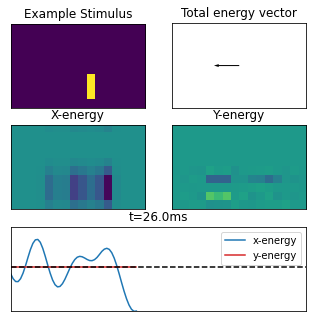

-1.002730495713101 -5.4643789493269423e-17


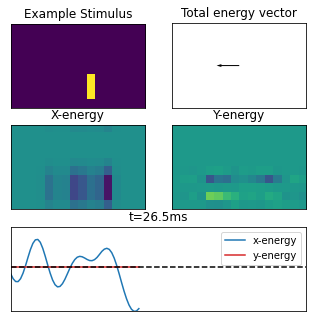

-0.8421593989029597 1.8214596497756474e-17


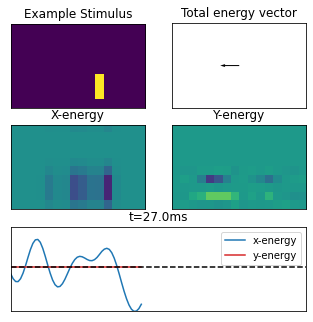

-0.6539607047717632 -4.0766001685454967e-17


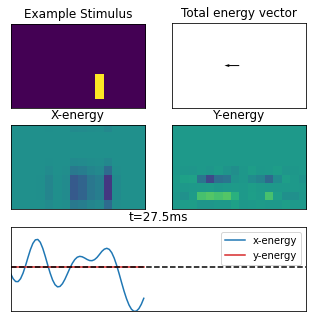

-0.4526454345718277 -3.5128150388530344e-17


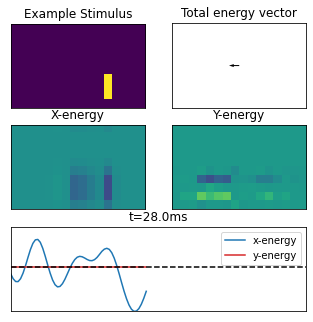

-0.25185485899749815 -1.6479873021779667e-17


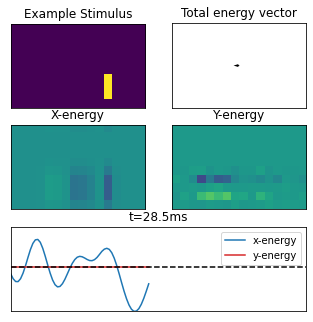

-0.06777859857355656 2.5153490401663703e-17


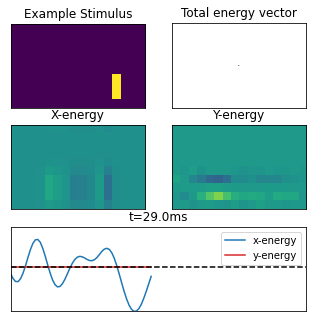

0.08740218155495205 1.8214596497756474e-16


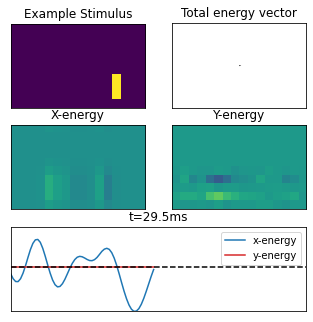

0.20616076769815453 1.9949319973733282e-16


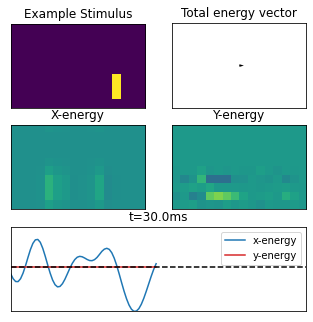

0.278176454695096 3.131175874138137e-16


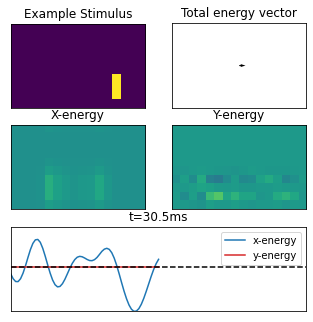

0.3093836184142159 1.0755285551056204e-16


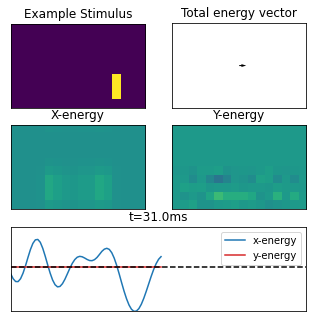

0.31925805435894605 3.2569433261464553e-16


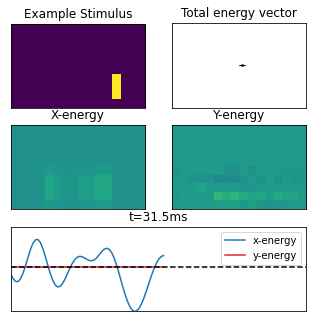

0.293553144362519 3.2395960913866872e-16


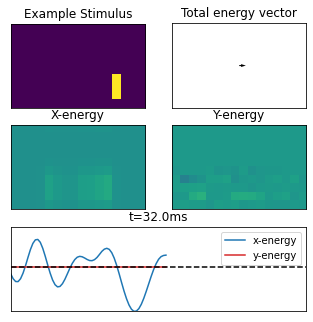

0.23846627374770818 1.929879867024198e-16


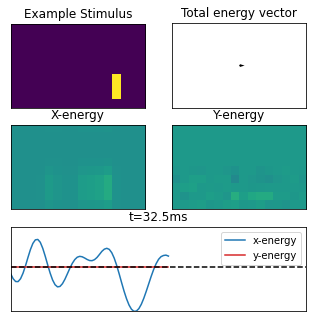

0.1619172310795798 2.64328489651966e-16


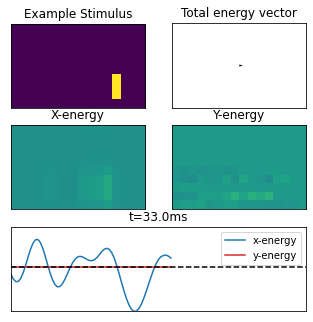

0.07356216626713295 1.6263032587282567e-16


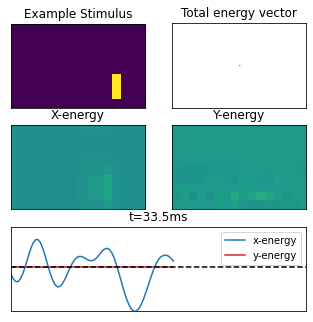

-0.015077207659056978 3.198396408832238e-16


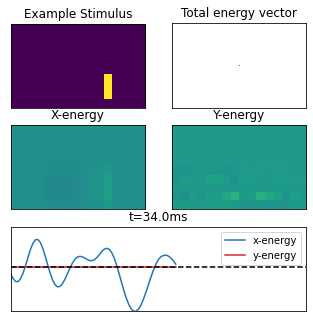

-0.09070757563383716 2.6291902682773483e-16


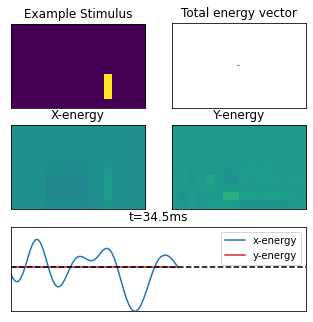

-0.13897452900644558 1.594861395726177e-16


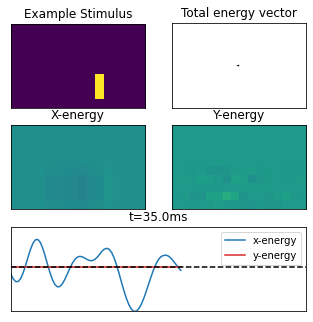

-0.14605559726609246 1.66045562716155e-16


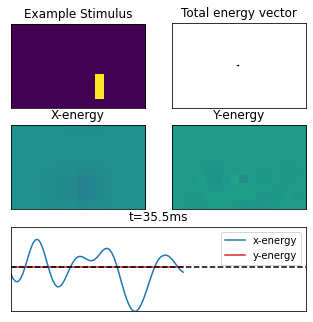

-0.10109460997102358 1.2760381943796584e-16


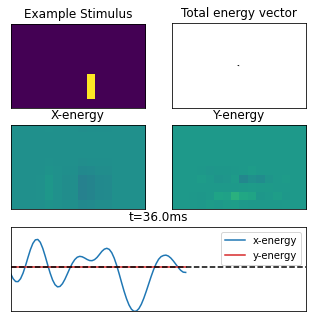

0.0028526671542550147 1.37287100090977e-16


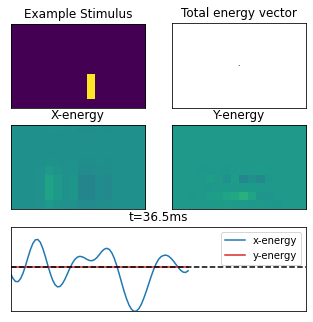

0.16367820989523835 1.749495730576922e-16


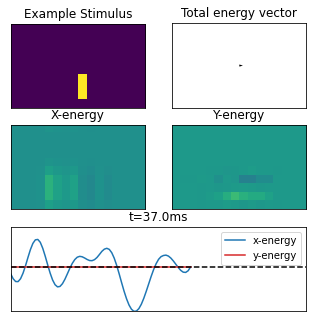

0.3651845140110095 1.0456113514085985e-16


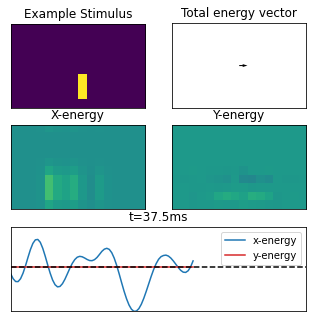

0.5859636196645037 3.3881317890172014e-19


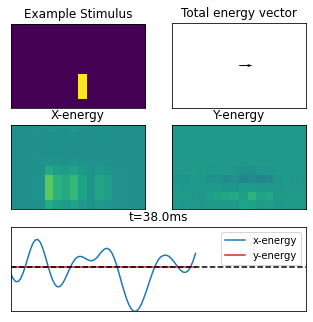

0.7972055103849637 4.0657581468206416e-17


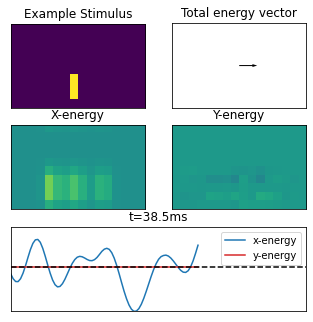

0.9684427423329913 -1.2609271266006417e-16


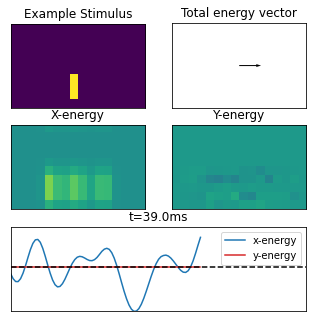

1.07069762421832 3.599551212651875e-17


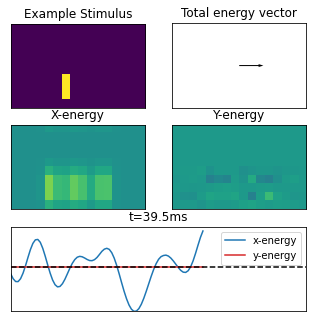

1.0874506752466186 1.2923689896027213e-16


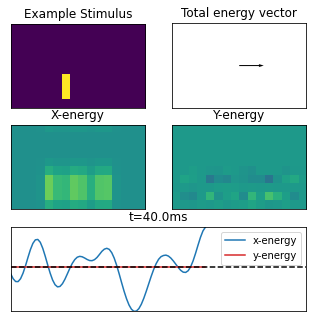

1.0113600175986188 -1.457167719820518e-16


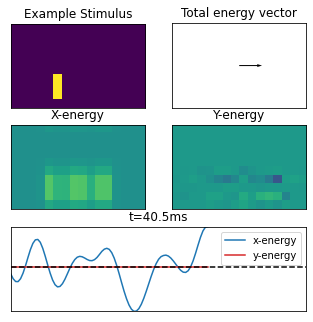

0.8474992868837055 -2.3505503099485736e-16


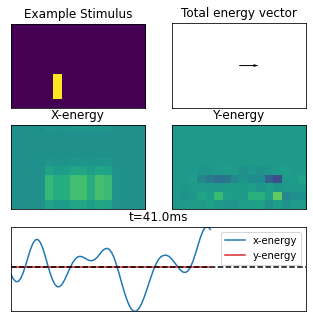

0.6165308533646456 -3.642919299551295e-16


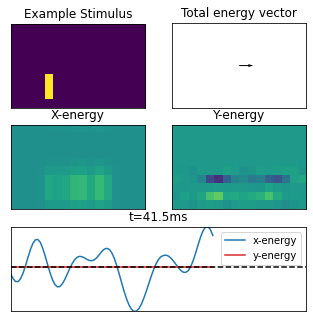

0.34698013387983717 -7.19910242530375e-17


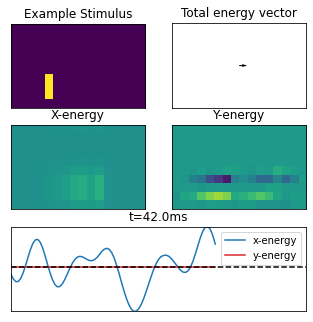

0.0702581899204779 -8.500145032286355e-17


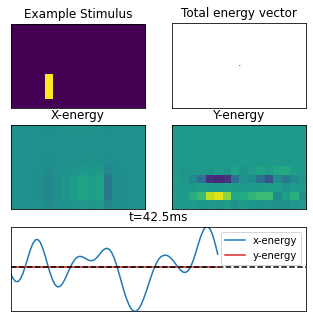

-0.17622501270460378 -2.246466901389965e-16


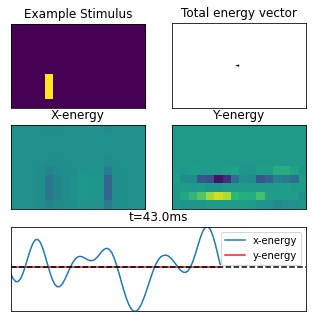

-0.3726483913295833 -2.498001805406602e-16


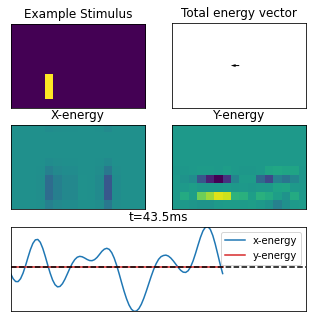

-0.5176820333409533 1.0928757898653885e-16


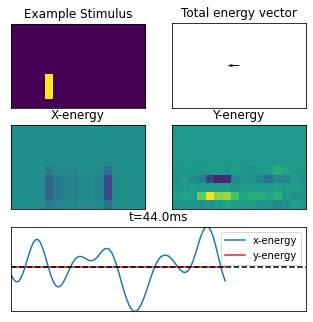

-0.5832921073258942 -6.635317295611287e-17


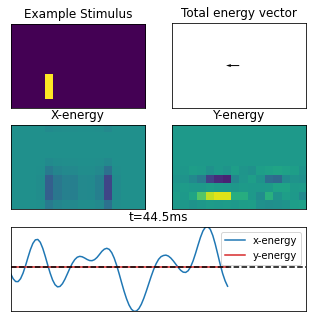

-0.5693985272968918 1.7477339020466331e-16


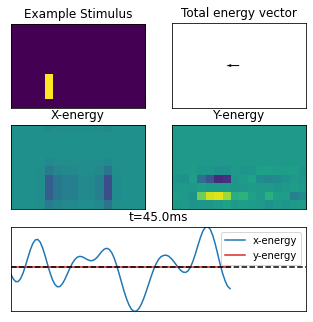

-0.4844193584323466 1.9255430583342559e-16


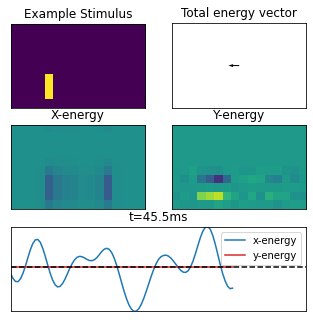

-0.3437146831939145 -1.1319070680748666e-16


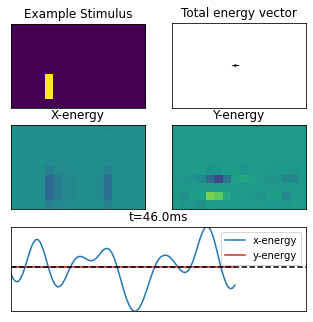

-0.16786780588431136 8.456776945386935e-17


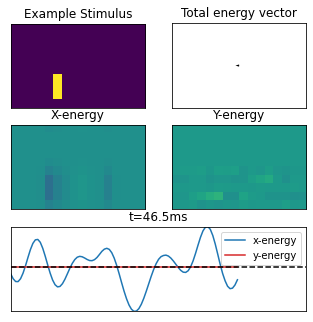

0.01908809128324429 1.4051260155412137e-16


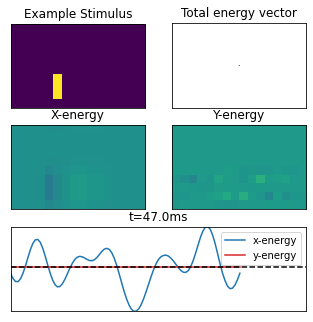

0.1916399045175544 3.131175874138137e-16


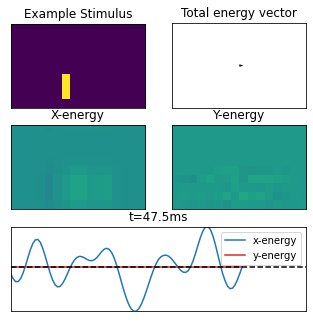

0.3251955435735319 9.389190813724468e-17


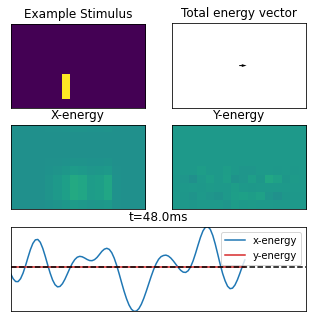

0.39900601181956485 2.5638670873850966e-16


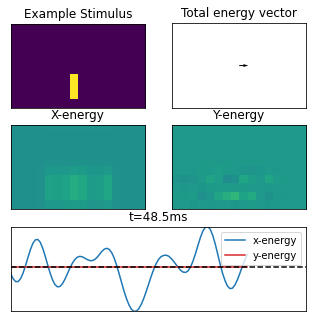

0.39746745443288983 4.87890977618477e-19


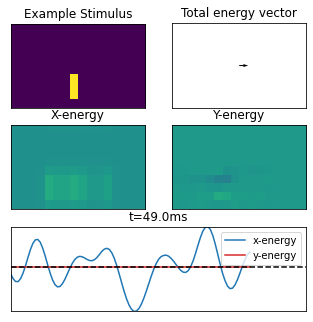

0.31563123520075975 -1.5535939505359475e-16


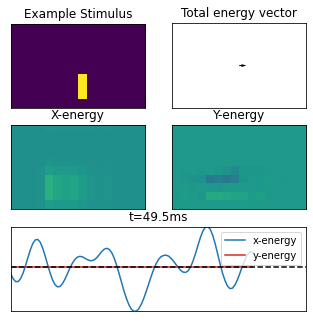

0.1675112968270186 -3.514170291568641e-17


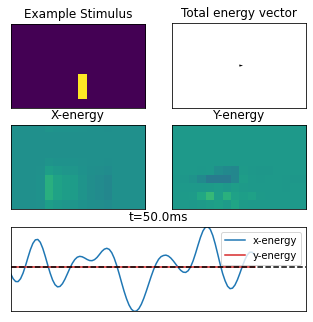

-0.031781823815222404 7.589415207398531e-18


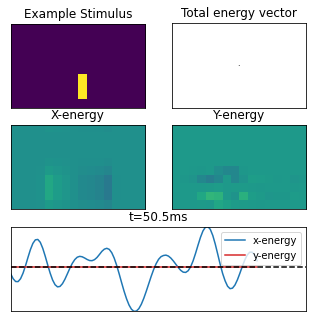

-0.2558307945441743 4.212125440106185e-17


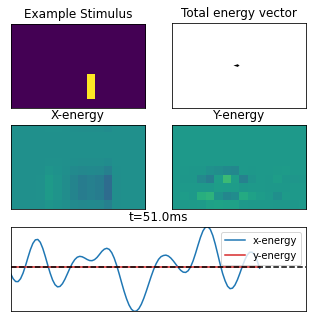

-0.46779273549743944 8.651933336434325e-17


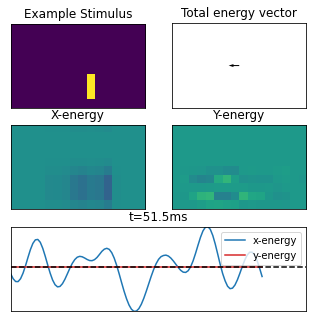

-0.6345381264286423 1.214306433183765e-17


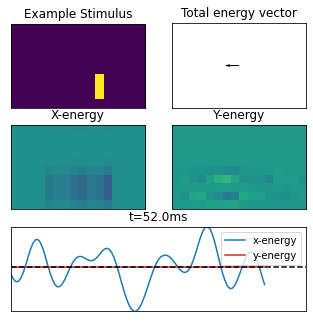

-0.730014686438493 1.1449174941446927e-16


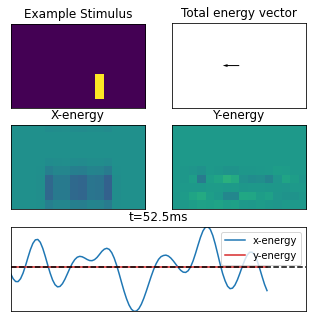

-0.7414347441056695 -1.0018028073766061e-16


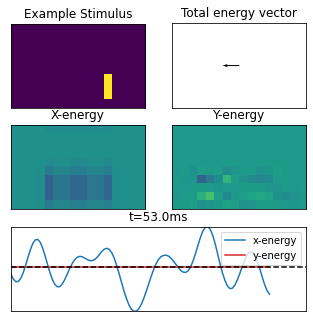

-0.664620367740552 3.9942008034365983e-16


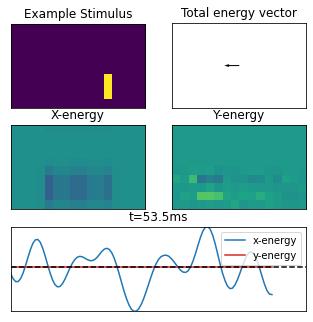

-0.5044760135495702 1.0581813203458523e-16


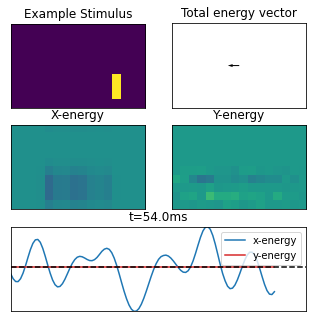

-0.2929727187429574 -1.8648277366750676e-17


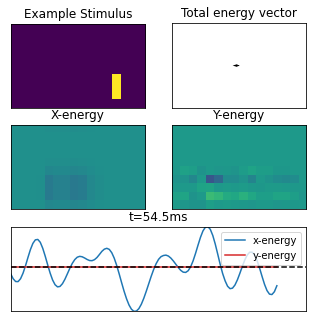

-0.05921946499175437 5.811323644522304e-17


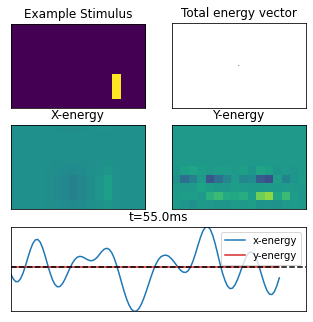

0.16612761759455066 -2.0773313624822265e-16


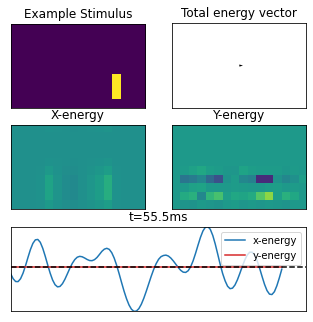

0.3554758213445015 -2.0383000842727483e-16


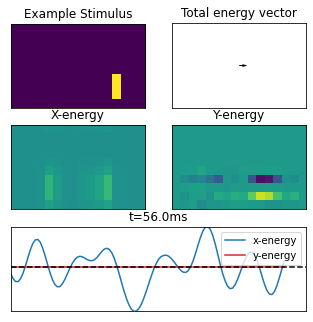

0.487817785642905 7.632783294297951e-17


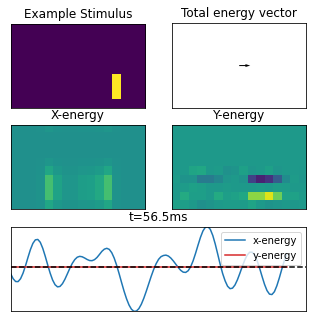

0.5507658673325365 -2.949029909160572e-17


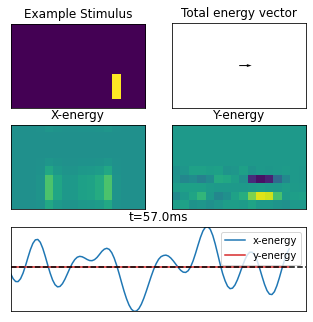

0.5411228112590716 -8.370040771588094e-17


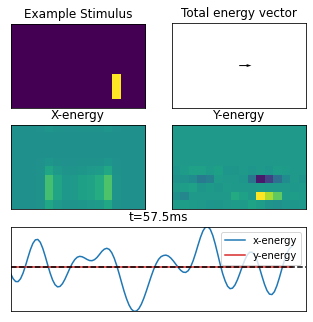

0.4643245252031468 1.205632815803881e-16


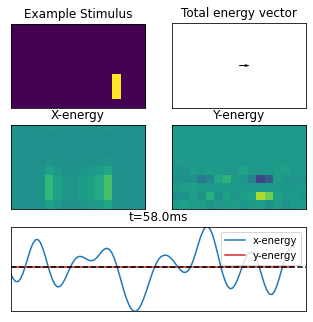

0.33320712649099865 5.334274688628682e-17


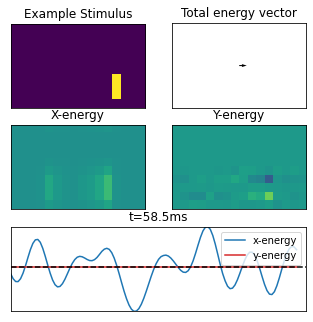

0.16451117431873638 1.4181364416110398e-16


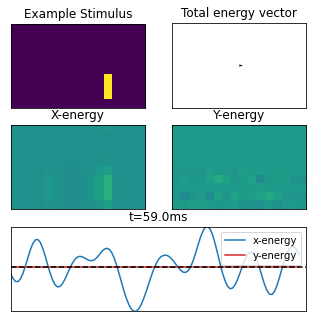

-0.016304725916549564 1.951563910473908e-16


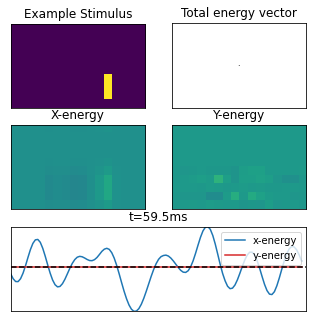

In [24]:
combined_img_files = []
process_combined = True
step_size = 1
x_energy_min = np.min(motion_contrast_x)
x_energy_max = np.max(motion_contrast_x)
y_energy_min = np.min(motion_contrast_y)
y_energy_max = np.max(motion_contrast_y)
matplotlib.rc ('figure', figsize= (5.3, 5.3))

for i in range(0, stim.shape[0], step_size):
        
    fig = plt.figure()
    gs = GridSpec(3, 2, figure=fig)
    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[2,:])
    dir_ax = fig.add_subplot(gs[0,1])
    ax_y_energy = fig.add_subplot(gs[1,1])
    
    ax0.imshow(np.transpose(stim)[:,:,i])
    ax0.set_title("Example Stimulus")
    ax0.set_yticks([])
    ax0.set_xticks([])
    ax1.imshow(np.transpose(motion_contrast_x)[:,:,i],
               vmin=x_energy_min,
               vmax=x_energy_max)
    ax1.set_title("X-energy")
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax_y_energy.imshow(np.transpose(motion_contrast_y)[:,:,i],
                       vmin=y_energy_min,
                       vmax=y_energy_max)
    ax_y_energy.set_title("Y-energy")
    ax_y_energy.set_yticks([])
    ax_y_energy.set_xticks([])
    
    ax2.plot(motion_contrast_per_frame_x[:i], color='tab:blue', label="x-energy")
    ax2.plot(motion_contrast_per_frame_y[:i], color='tab:red', label="y-energy")
    ax2.axhline(y=0.0, color='black', linestyle='--')
    ax2.set_xlim([0, motion_contrast_per_frame_x.shape[0]])
    y_max = max(np.max(motion_contrast_per_frame_x), np.max(motion_contrast_per_frame_y))
    y_min = min(np.min(motion_contrast_per_frame_x), np.min(motion_contrast_per_frame_y))
    ax2.set_ylim([y_min, y_max])
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_title("t="+str(i/2)+"ms")
    ax2.legend(loc='upper right')
    
    dir_ax.set_title("Total energy vector")
    dir_ax.set_yticks([])
    dir_ax.set_xticks([])
    x_max = max(-np.min(motion_contrast_per_frame_x), 
                np.max(motion_contrast_per_frame_x))
    y_max = max(-np.min(motion_contrast_per_frame_y), 
                np.max(motion_contrast_per_frame_y))
    norm = np.sqrt(x_max * x_max + y_max * y_max)
    dir_ax.set_xlim([-0.2, 0.2])
    dir_ax.set_ylim([-0.2, 0.2])
    dir_ax.quiver(0, 0,
                  motion_contrast_per_frame_x[i] / norm, 
                  motion_contrast_per_frame_y[i] / norm,
                  scale = 5)
    print(motion_contrast_per_frame_x[i], 
          motion_contrast_per_frame_y[i])
    
    combined_filename = "comb" + str(i/2) + ".png"
    plt.savefig(combined_filename)
    combined_img_files.append(imageio.imread(combined_filename))
    plt.show()

if process_combined:
    imageio.mimsave('comb_movie.gif', combined_img_files)
